In [1]:
#!/usr/bin/env python3
"""
Movie Data Preprocessor for CSV Generation
"""

import pandas as pd
import ast
import nltk
import re
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# Initialize NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Constants
MIN_GENRE_SAMPLES = 5    # Minimum movies per genre
MAX_GENRE_SAMPLES = 1000 # Maximum movies per genre
TEST_SIZE = 0.2          # Test set proportion

def clean_text(text):
    """Enhanced text cleaning pipeline"""
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    
    # Contraction handling
    contractions = {
        r"won't": "will not", r"can't": "cannot", r"n't": " not",
        r"'re": " are", r"'s": " is", r"'d": " would", 
        r"'ll": " will", r"'t": " not", r"'ve": " have", 
        r"'m": " am", r"what's": "what is"
    }
    
    for pat, repl in contractions.items():
        text = re.sub(pat, repl, text)
    
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", ' ', text)
    text = text.lower()
    
    tokens = nltk.word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(token) 
        for token in tokens 
        if (token not in stop_words) and (len(token) > 2) and (token.isalpha())
    ]
    
    return ' '.join(tokens)

def load_metadata(metadata_path):
    """Load and validate genre metadata"""
    try:
        df = pd.read_csv(
            metadata_path, 
            sep='\t', 
            header=None,
            usecols=[0, 8], 
            names=['movie_id', 'genres'],
            dtype={'movie_id': str}
        )
        df.dropna(inplace=True)
        
        def parse_genres(genre_json):
            try:
                genres_dict = ast.literal_eval(genre_json)
                return [
                    re.sub(r'[^a-z]', '', g.lower().strip())
                    for g in genres_dict.values()
                    if len(g.strip()) >= 4
                ]
            except:
                return []
        
        df['genres'] = df['genres'].apply(parse_genres)
        return df[df['genres'].map(len) > 0]
    
    except Exception as e:
        print(f"❌ Error loading metadata: {e}")
        raise

def load_summaries(summaries_path):
    """Load plot summaries"""
    try:
        return pd.read_csv(
            summaries_path,
            sep='\t',
            header=None,
            names=['movie_id', 'summary'],
            dtype={'movie_id': str}
        ).dropna()
    except Exception as e:
        print(f"❌ Error loading summaries: {e}")
        raise

def balance_genres(df):
    """Balance genre distribution with proper scoping"""
    exploded = df.explode('genres')
    genre_counts = exploded['genres'].value_counts()
    
    # Define valid_genres here so it's accessible later
    global valid_genres
    valid_genres = genre_counts[genre_counts >= MIN_GENRE_SAMPLES].index.tolist()
    
    if not valid_genres:
        raise ValueError("No genres meet the minimum sample threshold")
    
    df = df[df['genres'].apply(lambda x: any(g in valid_genres for g in x))]
    
    balanced_dfs = []
    for genre in valid_genres:
        genre_movies = df[df['genres'].apply(lambda x: genre in x)]
        if len(genre_movies) > MAX_GENRE_SAMPLES:
            genre_movies = genre_movies.sample(MAX_GENRE_SAMPLES, random_state=42)
        balanced_dfs.append(genre_movies)
    
    balanced_df = pd.concat(balanced_dfs).drop_duplicates(subset=['movie_id'])
    
    # Filter rare genre combinations
    genre_combos = balanced_df['genres'].apply(lambda x: tuple(sorted(x)))
    combo_counts = genre_combos.value_counts()
    valid_combos = combo_counts[combo_counts >= 2].index
    balanced_df = balanced_df[balanced_df['genres'].apply(
        lambda x: tuple(sorted(x)) in valid_combos
    )]
    
    print("\n🎭 Final Genre Distribution:")
    print(balanced_df.explode('genres')['genres'].value_counts())
    
    return balanced_df

def get_genre_tuple(genres):
    """Stratification helper using the global valid_genres"""
    return tuple(sorted(set(g for g in genres if g in valid_genres)))

def preprocess_data(metadata_path, summaries_path):
    print("🚀 Starting data preprocessing pipeline...")
    
    try:
        # Load and merge data
        meta = load_metadata(metadata_path)
        summaries = load_summaries(summaries_path)
        df = pd.merge(summaries, meta, on='movie_id')
        print(f"Initial dataset size: {len(df)} movies")
        
        # Clean text
        tqdm.pandas(desc="Cleaning summaries")
        df['cleaned_summary'] = df['summary'].progress_apply(clean_text)
        
        # Balance genres
        balanced_df = balance_genres(df)
        print(f"Balanced dataset size: {len(balanced_df)} movies")
        
        # Train-test split
        train, test = train_test_split(
            balanced_df[['movie_id', 'cleaned_summary', 'genres']],
            test_size=TEST_SIZE,
            random_state=42,
            stratify=balanced_df['genres'].apply(get_genre_tuple)
        )
        
        # Save outputs to Dataset folder
        train.to_csv("Dataset/train_cleaned.csv", index=False)
        test.to_csv("Dataset/test_cleaned.csv", index=False)
        print("\n✅ Successfully created:")
        print(f"- Dataset/train_cleaned.csv ({len(train)} movies)")
        print(f"- Dataset/test_cleaned.csv ({len(test)} movies)")
        
        return train, test
        
    except Exception as e:
        print(f"\n❌ Critical error: {str(e)}")
        raise

if __name__ == "__main__":
    preprocess_data('Dataset/movie.metadata.csv', 'Dataset/plot_summaries.txt')

🚀 Starting data preprocessing pipeline...
Initial dataset size: 41790 movies


Cleaning summaries: 100%|███████████████████████████████████████████████████████| 41790/41790 [00:59<00:00, 700.20it/s]



🎭 Final Genre Distribution:
genres
drama                  6452
comedy                 3560
romancefilm            2544
thriller               2160
worldcinema            2115
                       ... 
absurdism                 2
dogme                     2
mythologicalfantasy       2
educational               2
standupcomedy             2
Name: count, Length: 226, dtype: int64
Balanced dataset size: 16754 movies

✅ Successfully created:
- Dataset/train_cleaned.csv (13403 movies)
- Dataset/test_cleaned.csv (3351 movies)


In [ ]:
import pandas as pd
from translate import Translator  
from gtts import gTTS
import os
import time  # Added import for time module
from tqdm import tqdm

# Load cleaned summaries
df = pd.read_csv("Dataset/test_cleaned.csv")

# Initialize translator
translator = Translator(to_lang="en")  # Default target language

# Define languages and their codes
languages = {
    'arabic': 'ar',
    'urdu': 'ur',
    'korean': 'ko'
}

# Prepare columns for translations
for lang in languages:
    df[f'translated_summary_{lang}'] = ''

# Create audio output directory
audio_dir = "tts_audio"
os.makedirs(audio_dir, exist_ok=True)

print("🌐 Translating and generating TTS for Arabic, Urdu, and Korean.")

# Process first 50 rows
for idx, row in tqdm(df.iloc[:50].iterrows(), total=50):
    summary = row['cleaned_summary']
    movie_id = row['movie_id']

    for lang, lang_code in languages.items():
        try:
            # Translate summary
            translator = Translator(to_lang=lang_code)
            translated = translator.translate(summary)
            df.at[idx, f'translated_summary_{lang}'] = translated

            # Generate TTS audio
            tts = gTTS(text=translated, lang=lang_code)
            audio_path = os.path.join(audio_dir, f"{movie_id}_{lang}.mp3")
            tts.save(audio_path)
            time.sleep(1)  # Add delay to avoid rate limiting

        except Exception as e:
            print(f"⚠️ Error on row {idx} (movie_id={movie_id}) for {lang}: {e}")
            continue

# Save the translations
df.to_csv("Dataset/test_translated.csv", index=False)
print("✅ Translation complete! Saved to test_translated.csv")

📥 Loading and validating data...
🔍 Selected 48 genres: drama, comedy, romancefilm, thriller, worldcinema, action, shortfilm, blackandwhite, horror, familyfilm...
🤖 Training optimized model...


C:\Users\Faiq\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_label.py:909: UserWarning: unknown class(es) ['absurdism', 'actioncomedy', 'actionthrillers', 'addictiondrama', 'adult', 'adventurecomedy', 'airplanesandairports', 'alienfilm', 'animalpicture', 'animatedcartoon', 'animatedmusical', 'anime', 'artfilm', 'autoracing', 'avantgarde', 'backstagemusical', 'baseball', 'beachfilm', 'biography', 'biopicfeature', 'blackcomedy', 'blaxploitation', 'bmovie', 'boxing', 'bruceploitation', 'buddycop', 'buddyfilm', 'bwestern', 'caperstory', 'cavalryfilm', 'chasemovie', 'childhooddrama', 'childrens', 'childrensfantasy', 'christianfilm', 'christmasmovie', 'combatfilms', 'comedyhorror', 'comedyoferrors', 'comedyofmanners', 'comedythriller', 'comedywestern', 'comingofage', 'computeranimation', 'costumeadventure', 'costumedrama', 'costumehorror', 'courtroomdrama', 'creaturefilm', 'crime', 'crimecomedy', 'crimedrama', 'cult', 'culturesociety', 'dance', 'detective', 

📊 Evaluating model performance...

🔥 Key Metrics:
Hamming Loss: 0.0919
Micro F1 Score: 0.4663
Subset Accuracy (Exact Match Ratio): 0.0252

Classification Report:
                       precision    recall  f1-score   support

                drama       0.63      0.74      0.68      1291
               comedy       0.47      0.72      0.57       704
          romancefilm       0.46      0.74      0.57       522
             thriller       0.42      0.71      0.52       433
          worldcinema       0.36      0.70      0.47       406
               action       0.38      0.74      0.50       356
            shortfilm       0.57      0.79      0.66       361
        blackandwhite       0.32      0.69      0.44       330
               horror       0.58      0.82      0.68       298
           familyfilm       0.41      0.74      0.53       250
         crimefiction       0.34      0.72      0.46       251
            animation       0.58      0.81      0.68       234
                in

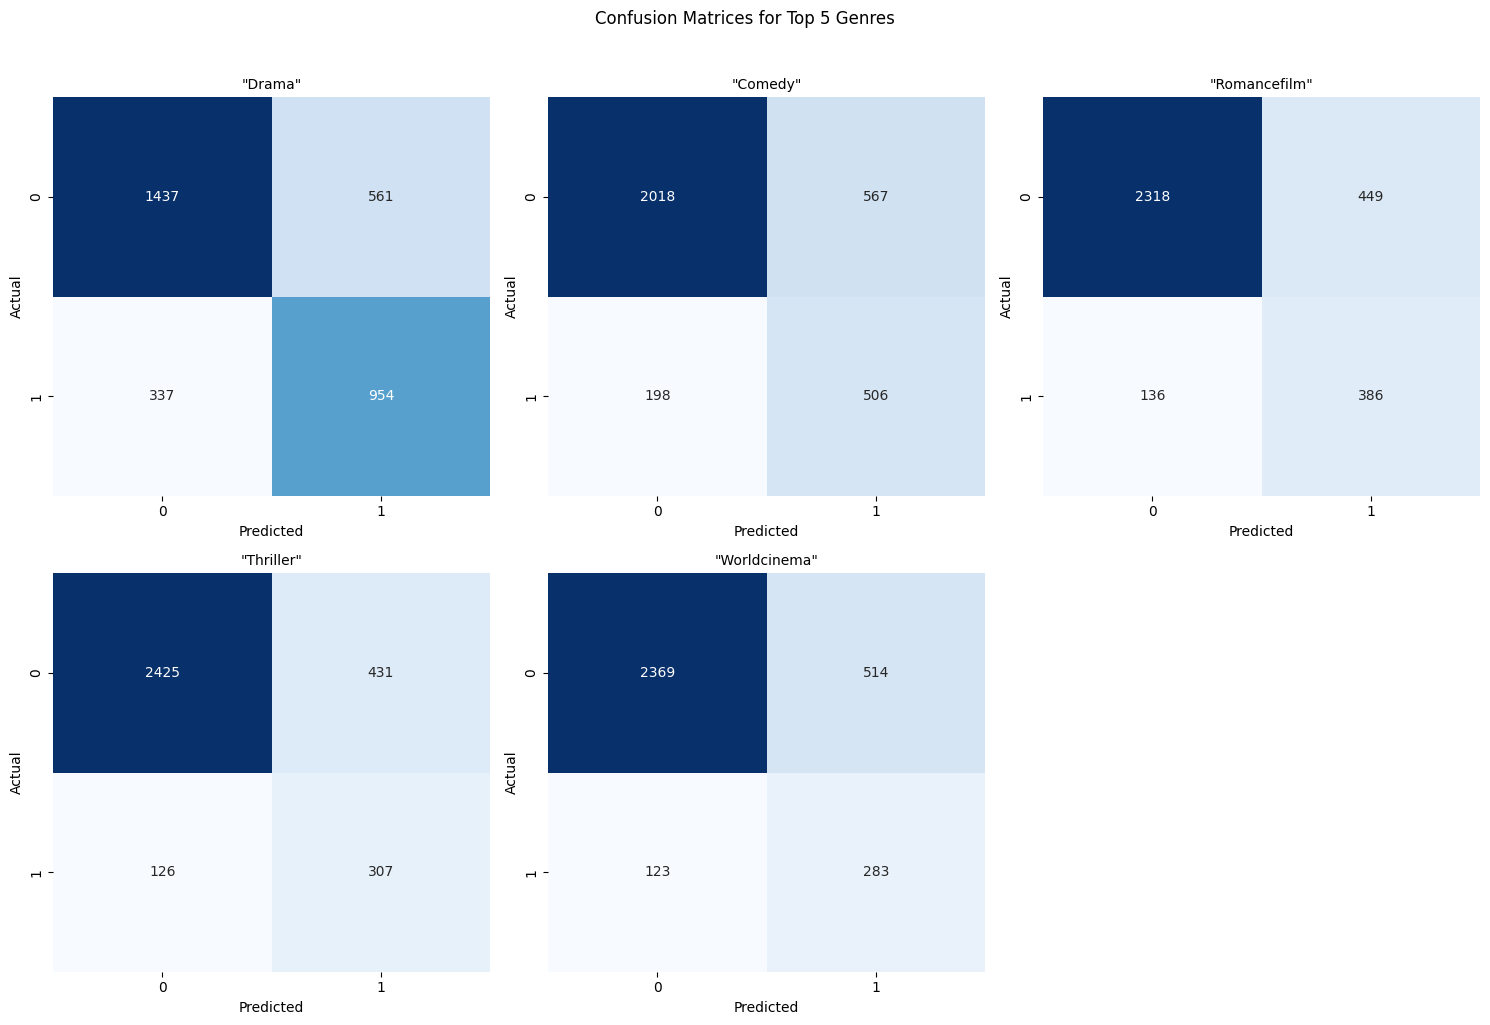

💾 Saving models...
✅ Done! Use these files in your GUI.


In [2]:
import pandas as pd
import ast
import joblib
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report,
    hamming_loss,
    f1_score,
    accuracy_score,
    multilabel_confusion_matrix
)
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

print("📥 Loading and validating data...")

def load_data(path):
    df = pd.read_csv(path)
    assert {'cleaned_summary', 'genres'}.issubset(df.columns)
    df['genres'] = df['genres'].apply(ast.literal_eval)
    return df

train_df = load_data("Dataset/train_cleaned.csv")
test_df = load_data("Dataset/test_cleaned.csv")

def clean_genres(genre_list):
    return [str(g).strip().lower() for g in genre_list if len(str(g).strip()) >= 4]

train_df['genres'] = train_df['genres'].apply(clean_genres)
test_df['genres'] = test_df['genres'].apply(clean_genres)

# Compute genre frequencies
all_genres = [g for genres in train_df['genres'] for g in genres]
genre_counts = pd.Series(all_genres).value_counts()
selected_genres = genre_counts[genre_counts >= 150].index.tolist()
print(f"🔍 Selected {len(selected_genres)} genres: {', '.join(selected_genres[:10])}...")

# Filter rows that have at least one of the selected genres
def filter_by_selected(df, allowed_genres):
    return df[df['genres'].apply(lambda gs: any(g in allowed_genres for g in gs))].copy()

train_df = filter_by_selected(train_df, selected_genres)
test_df = filter_by_selected(test_df, selected_genres)

# Binarize targets using only selected genres
mlb = MultiLabelBinarizer(classes=selected_genres)
y_train = mlb.fit_transform(train_df['genres'])
y_test = mlb.transform(test_df['genres'])

# Define text vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english',
    min_df=3,
    max_df=0.75,
    sublinear_tf=True
)

# Define classifier
clf = MultiOutputClassifier(
    LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        solver='liblinear'
    )
)

# Full pipeline
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('select', SelectKBest(chi2, k=3000)),
    ('clf', clf)
])

print("🤖 Training optimized model...")
pipeline.fit(train_df['cleaned_summary'], y_train)

# Evaluate
print("📊 Evaluating model performance...")
y_pred = pipeline.predict(test_df['cleaned_summary'])

print("\n🔥 Key Metrics:")
print(f"Hamming Loss: {hamming_loss(y_test, y_pred):.4f}")
print(f"Micro F1 Score: {f1_score(y_test, y_pred, average='micro'):.4f}")
print(f"Subset Accuracy (Exact Match Ratio): {accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=selected_genres, zero_division=0))

# Confusion Matrices for selected genres - Modified to show all top 5 in one figure
print("\n📉 Plotting Confusion Matrices for top 5 genres...")
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Create a single figure with subplots for all 5 genres
plt.figure(figsize=(15, 10))
for idx, genre in enumerate(selected_genres[:5]):  # Plot top 5 genres
    cm = conf_matrices[idx]
    plt.subplot(2, 3, idx+1)  # 2 rows, 3 columns layout (5 plots)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'"{genre.title()}"', fontsize=10)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
plt.suptitle('Confusion Matrices for Top 5 Genres', fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

# Save model and label binarizer
print("💾 Saving models...")
joblib.dump(pipeline, "models/genre_model.pkl", compress=3)
joblib.dump(mlb, "models/mlb.pkl", compress=3)
joblib.dump(selected_genres, "models/selected_genres.pkl", compress=3)

print("✅ Done! Use these files in your GUI.")

In [1]:
import tkinter as tk
from tkinter import ttk, messagebox, scrolledtext
import joblib
from gtts import gTTS
import pygame
from translate import Translator
import threading
import os
import time
import re

class FilmceptionApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Filmception - Movie AI Processor")
        self.root.geometry("800x600")
        
        pygame.mixer.init()
        self.models_loaded = False
        self.load_models_async()
        self.create_loading_screen()
    
    def load_models_async(self):
        def load_task():
            try:
                start_time = time.time()
                self.model = joblib.load("models/genre_model.pkl")  # Full pipeline
                self.mlb = joblib.load("models/mlb.pkl")
                load_time = time.time() - start_time
                print(f"Models loaded in {load_time:.2f} seconds")
                self.root.after(0, self.create_main_ui)
            except Exception as e:
                self.root.after(0, lambda: messagebox.showerror(
                    "Error", 
                    f"Failed to load models:\n{str(e)}"
                ))
                self.root.after(0, self.root.destroy)
        threading.Thread(target=load_task, daemon=True).start()
    
    def create_loading_screen(self):
        self.loading_frame = ttk.Frame(self.root)
        self.loading_frame.pack(expand=True, fill=tk.BOTH)
        
        ttk.Label(
            self.loading_frame, 
            text="Loading Filmception...", 
            font=('Helvetica', 16)
        ).pack(pady=50)
        
        self.progress = ttk.Progressbar(
            self.loading_frame, 
            mode='indeterminate'
        )
        self.progress.pack(pady=10)
        self.progress.start()
    
    def create_main_ui(self):
        self.loading_frame.destroy()
        self.models_loaded = True
        
        main_frame = ttk.Frame(self.root, padding="20")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        ttk.Label(main_frame, text="Enter Movie Summary:").pack(anchor='w')
        self.summary_text = scrolledtext.ScrolledText(
            main_frame, height=10, wrap=tk.WORD, font=('Helvetica', 10)
        )
        self.summary_text.pack(fill=tk.BOTH, expand=True, pady=5)
        
        btn_frame = ttk.Frame(main_frame)
        btn_frame.pack(fill=tk.X, pady=10)
        
        self.predict_btn = ttk.Button(
            btn_frame, text="Predict Genres", command=self.start_prediction, state='normal'
        )
        self.predict_btn.pack(side=tk.LEFT, padx=5)
        
        trans_frame = ttk.Frame(btn_frame)
        trans_frame.pack(side=tk.LEFT, padx=20)
        
        ttk.Label(trans_frame, text="Language:").pack(anchor='w')
        self.lang_var = tk.StringVar(value='en')
        lang_menu = ttk.Combobox(
            trans_frame, textvariable=self.lang_var,
            values=['en', 'ar', 'ur', 'ko'], state='readonly', width=7
        )
        lang_menu.pack()
        
        self.audio_btn = ttk.Button(
            trans_frame, text="Play Audio", command=self.start_audio_translation, state='normal'
        )
        self.audio_btn.pack(pady=5)
        
        ttk.Label(main_frame, text="Results:").pack(anchor='w')
        self.results_text = scrolledtext.ScrolledText(
            main_frame, height=8, wrap=tk.WORD, font=('Helvetica', 10), state='disabled'
        )
        self.results_text.pack(fill=tk.BOTH, expand=True)
        
        self.status_var = tk.StringVar(value="Ready")
        status_bar = ttk.Label(
            main_frame, textvariable=self.status_var,
            relief=tk.SUNKEN, anchor='w'
        )
        status_bar.pack(fill=tk.X, pady=(10, 0))
    
    def set_busy_state(self, busy=True):
        state = 'disabled' if busy else 'normal'
        self.predict_btn.config(state=state)
        self.audio_btn.config(state=state)
        self.status_var.set("Processing..." if busy else "Ready")
        self.root.update()
    
    def clean_text(self, text):
        return re.sub(r"[^a-zA-Z\s]", "", text.lower())
    
    def start_prediction(self):
        if not self.models_loaded:
            messagebox.showerror("Error", "Models not loaded yet")
            return
        
        summary = self.summary_text.get("1.0", tk.END).strip()
        if not summary:
            messagebox.showwarning("Warning", "Please enter a movie summary")
            return
        
        self.set_busy_state(True)
        
        def prediction_task():
            try:
                cleaned = self.clean_text(summary)
                y_pred = self.model.predict([cleaned])
                genres = self.mlb.inverse_transform(y_pred)[0]

                result = "Predicted Genres:\n"
                result += ", ".join(genres) if genres else "No genres predicted"

                self.results_text.config(state='normal')
                self.results_text.delete("1.0", tk.END)
                self.results_text.insert(tk.END, result)
                self.results_text.config(state='disabled')
            except Exception as e:
                messagebox.showerror("Error", f"Prediction failed: {str(e)}")
            finally:
                self.set_busy_state(False)

        threading.Thread(target=prediction_task, daemon=True).start()
    
    def start_audio_translation(self):
        if not self.models_loaded:
            messagebox.showerror("Error", "Models not loaded yet")
            return
        
        summary = self.summary_text.get("1.0", tk.END).strip()
        if not summary:
            messagebox.showwarning("Warning", "Please enter a movie summary")
            return
        
        lang = self.lang_var.get()
        self.set_busy_state(True)
        
        def audio_task():
            try:
                # Generate unique filename for each translation
                audio_file = f"temp_audio_{lang}_{int(time.time())}.mp3"
                
                # Clean up any previous audio files
                for f in os.listdir():
                    if f.startswith("temp_audio_") and f.endswith(".mp3"):
                        try:
                            os.remove(f)
                        except:
                            pass
                
                # Split long text into chunks
                max_chars = 450
                text_chunks = [summary[i:i+max_chars] for i in range(0, len(summary), max_chars)]
                
                translator = Translator(to_lang=lang)
                translated_chunks = []
                
                for chunk in text_chunks:
                    translated = translator.translate(chunk)
                    translated_chunks.append(translated)
                    time.sleep(1)  # Avoid rate limiting
                
                full_translation = " ".join(translated_chunks)
                
                # Update results
                result = f"Translation ({lang}):\n{full_translation}"
                self.results_text.config(state='normal')
                self.results_text.delete("1.0", tk.END)
                self.results_text.insert(tk.END, result)
                self.results_text.config(state='disabled')

                # Generate and play audio
                tts = gTTS(text=full_translation, lang=lang)
                tts.save(audio_file)
                
                if pygame.mixer.music.get_busy():
                    pygame.mixer.music.stop()
                
                pygame.mixer.music.load(audio_file)
                time.sleep(0.2)  # Ensure file is fully loaded
                pygame.mixer.music.play()
                
            except Exception as e:
                messagebox.showerror("Error", f"Translation failed: {str(e)}")
            finally:
                self.set_busy_state(False)

        threading.Thread(target=audio_task, daemon=True).start()

if __name__ == "__main__":
    if not os.path.exists("models"):
        os.makedirs("models")
        messagebox.showwarning(
            "Warning", 
            "Created 'models' directory\n"
            "Please ensure model files are present:\n"
            "- genre_model.pkl\n"
            "- mlb.pkl"
        )
    
    root = tk.Tk()
    app = FilmceptionApp(root)
    root.eval('tk::PlaceWindow . center')
    root.mainloop()


pygame 2.6.1 (SDL 2.28.4, Python 3.13.1)
Hello from the pygame community. https://www.pygame.org/contribute.html
Models loaded in 1.25 seconds
